# In this notebook I implement a Recurrent Neural Network 

In [1]:
#%% imports 
from sklearn.cross_validation import train_test_split
from sklearn.datasets import make_moons
from sklearn import datasets
import numpy as np
import scipy.io as scio
import numpy.random as rng
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline  
%config InlineBackend.figure_format = 'svg'
matplotlib.rcParams['figure.figsize'] = (8,5)
rng.seed(1)
import tensorflow as tf
from scipy.stats import mode

# Generate data (from lorenz_system)
Here I generate data from lorenz attractor to train the RNN on
https://en.wikipedia.org/wiki/Lorenz_system


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


class lorenz_system:
    def __init__(self, s0, sig=10, rho=28, bta=8./3., dt = 0.01):
        self.s = s0; # system state (3D)
        self.dt = dt; # integration step (the smaller the more accurate the system updates)
        
        ############  Lorentz attractor parameters ##############
        ############ default are values used by Lorenz that give chaotic behaviour #####
        self.sig = sig; 
        self.rho = rho;
        self.bta = bta;
        self.t = 0;
    def update_state(self):
        s_dot = np.array([self.sig*(self.s[1] - self.s[0]), 
                               self.s[0]*(self.rho-self.s[2]) - self.s[1], 
                               self.s[0]*self.s[1] - self.bta*self.s[2]]);
        self.s = s_dot * self.dt + self.s;
        self.t += self.dt;
    def run_system(self, nsteps):
        st = [self.s];
        t = [self.t];
        for i in range(nsteps):
            self.update_state();
            st+= [self.s];
            t += [self.t];
        return np.array(st), np.array(t)



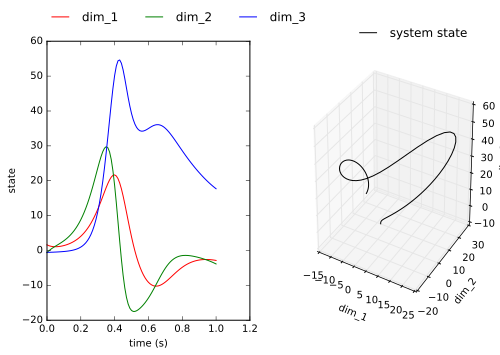

In [3]:
# Setting initial values
s0 = rng.randn(3);
lorentz = lorenz_system(s0)
st, t = lorentz.run_system(100)

fig = plt.figure("Lorenz System");
ax = fig.add_subplot(1,2,1)
ax.plot(t, st[:,0], 'r', label = 'dim_1')
ax.plot(t, st[:,1], 'g', label = 'dim_2')
ax.plot(t, st[:,2], 'b', label = 'dim_3')
ax.set_xlabel('time (s)')
ax.set_ylabel('state')
plt.legend(bbox_to_anchor=(0.3, 1.02, 1., .102), borderaxespad=0., loc = 1., frameon = False, ncol = 3)
# ax.set_aspect(0.4)
ax = fig.add_subplot(1,2,2, projection='3d')
ax.plot(st[:,0],st[:,1],st[:,2], 'k', label = 'system state')
ax.set_xlabel("dim_1")
ax.set_ylabel("dim_2")
ax.set_zlabel("dim_3")
plt.legend(bbox_to_anchor=(0.3, 1.02, 1., .102), loc = 2., borderaxespad=0., frameon = False)
ax.set_aspect('equal')
plt.show()

# Build Recurrent Neural Network Class

In [ ]:
class RNN:
    def __init__(self, layer_sizes, dt, g = 1.5):
        self.dataType = tf.float64;
        self.layer_sizes = layer_sizes; # size of input, recurrent, and output lauers
        self.g = g; # gain of network
        self.N = self.layer_sizes[1];
        self.Win = tf.Variable(initial_value=0.1*(tf.random_uniform(shape = (self.N, layer_sizes[0]), dtype=self.dataType)-0.5)); # initialize input matrix
        self.Wrnn = tf.Variable(initial_value= tf.truncated_normal(shape= (self.N, self.N), 
                    stddev= self.g/np.sqrt(self.N),dtype=self.dataType));
        self.Wo = tf.Variable(initial_value= 0.1*(tf.random_uniform(shape = (layer_sizes[2], self.N),dtype=self.dataType)-0.5));
        
        self.u = tf.placeholder(shape=[layer_sizes[0], 1], dtype=self.dataType);
        self.x = tf.zeros(shape = [self.N, 1], dtype=self.dataType); # system state
        self.r = tf.nn.tanh(self.x);         # activity rate
        self.z = tf.matmul(self.Wo, self.r); # network output

        self.dt = dt;
        self.t = 0;
    #### function that performs integration of the state after one time step
    def update_state(self):
        self.x = (1. - dt) * self.x + tf.matmul(self.Wrnn , self.r) * dt + tf.matmul(self.Win, self.u);
        self.r = tf.nn.tanh(self.x);
        self.z = tf.matmul(self.Wo, self.r);
    #### function that run the dynamics of the system for multiple time steps (nsteps)
    def run_system(self, nsteps):
        xt = [self.x];
        rt = [self.r];
        zt = [self.z];
        t = [self.t];
        for i in range(nsteps):
            self.update_state();
            xt+= [self.x];
            rt+= [self.r];
            zt+= [self.z];
            t += [self.t];
        return tf.squeeze(tf.pack(xt)), tf.squeeze(tf.pack(rt)), tf.squeeze(tf.pack(zt)), tf.squeeze(tf.pack(t))
    #### function that resets the network to states at time step 0
    def reset(self):
        self.x = tf.zeros(shape = [self.N, 1], dtype=self.dataType);
        self.r = tf.nn.tanh(self.x);
        self.z = tf.matmul(self.Wo, self.r);
        self.t = 0;




# Build force learning optimizer
Force learning is developed in the following paper:
http://www.sciencedirect.com/science/article/pii/S0896627309005479


In [5]:
class force_learning:
    def __init__(self, rnn, alpha = 1.):
        self.rnn = rnn;
        self.dataType = rnn.dataType;
        self.alpha = alpha;
        self.N = rnn.layer_sizes[1]; # number of units
        self.d = rnn.layer_sizes[2]; # output dimensionality
        self.target = tf.placeholder(shape = [self.d], dtype=self.dataType)
        self.P = tf.Variable(initial_value=tf.cast(1./self.alpha * tf.eye(self.N), dtype=self.dataType));
        self.Wfb = tf.Variable(initial_value= tf.truncated_normal(shape = (self.N, self.d), stddev=0.1, dtype=self.dataType)); # feedback matrix used for teh low rank modification of the Rnn weights
        self.Wrnn = rnn.Wrnn;
        self.Wo = rnn.Wo;

    ### learnin step based on recursive least squares
    def train_step(self):
        r = self.rnn.r;
        k = tf.matmul(self.P,r);
        rPr = tf.matmul(tf.transpose(r), k)
        c = tf.squeeze(1./(1.+rPr));
        target = self.target;
        self.P = self.P - c * tf.matmul(k, tf.transpose(k));
        z = tf.matmul(self.Wo, r);
        e = (tf.squeeze(z)-tf.squeeze(target))[:, tf.newaxis];
        dw = - c * tf.matmul(k, tf.transpose(e));
        self.Wrnn = self.Wrnn + tf.matmul(self.Wfb, tf.transpose(dw));
        self.Wo = self.Wo + tf.transpose(dw);
        return tf.reduce_sum(e**2)
        

# Training

In [6]:
dt = 0.01;
layer_sizes = [1, 1000, 3]
rnnmdl = RNN(layer_sizes, dt)
optimizer = force_learning(rnnmdl)
init = tf.global_variables_initializer()


In [7]:
sess = tf.InteractiveSession();

In [ ]:
sess.run(init)
maxiter = 100;
curr_err = [];
for i in range(maxiter):
    rnnmdl.reset();
    e = [];
    z = [];
    for t in range(st.shape[0]):
        feed_dict = {rnnmdl.u: np.array([1])[:, np.newaxis], optimizer.target: st[t,:]};
        e += [sess.run(optimizer.train_step(), feed_dict=feed_dict)]
#         z += [sess.run(tf.squeeze(rnnmdl.z), feed_dict=feed_dict)];
        rnnmdl.update_state()
    print ("iter %d, mean square error = %.3f" %(i, np.mean(np.array(e))))
        

iter 0, mean square error = 8.981
iter 1, mean square error = 0.758
iter 2, mean square error = 0.631
iter 3, mean square error = 0.633
iter 4, mean square error = 0.652
iter 5, mean square error = 0.666


In [ ]:
plt.plot(np.array(z), 'b--')
plt.plot(st[0:t,:], 'k--')
plt.pause(0.00001)
plt.show()